In [20]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Utility.Get_dataset_clean_function import download_data_from_blob
from collections import Counter
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt

In [2]:
df = download_data_from_blob('data_for_model_2022.csv')

In [3]:
df.drop(['Unnamed: 0','date_mutation'], axis=1, inplace=True)
df = df.drop(df[df['valeur_fonciere']<100000].index)

In [7]:
df.head()

,code_postal,code_commune,code_departement,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,valeur_fonciere,longitude,latitude,...,TOUYA,VADC,VAGUE,VANIL,VAOC,VCHAS,VDQS,VIGNE,VIVIE,Unnamed: 213
0,75018.0,75118,75,2,61.00,2.0,0.0,580000.0,2.348168,48.884490,...,0,0,0,0,0,0,0,0,0,2
1,75003.0,75103,75,1,40.66,3.0,0.0,605000.0,2.362871,48.863374,...,0,0,0,0,0,0,0,0,0,1
2,75009.0,75109,75,3,66.26,3.0,0.0,716250.0,2.332324,48.880353,...,0,0,0,0,0,0,0,0,0,1
3,75010.0,75110,75,2,35.19,2.0,0.0,320000.0,2.362613,48.879658,...,0,0,0,0,0,0,0,0,0,1
4,75020.0,75120,75,2,32.52,1.0,0.0,320000.0,2.405513,48.872782,...,0,0,0,0,0,0,0,0,0,1


In [9]:
lkm = df[[
    'code_postal',
    'nombre_lots',
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'surface_terrain',
    'valeur_fonciere',
    'longitude','latitude',
    'Appartement',
    'Maison',
    'RUE',
    'AV',
    'BD',
    'CITE',
    'OTHER',
    'PL',
    'IMP',
    'ALL',
    'QUAI',
    'VC',
    'SQ',
    'CRS',
    'VOIE',
    'CR',
    'RLE'
]]

In [4]:
# Recuperation données pour construction modele ml

classe_liste_prefixe_voie = download_data_from_blob('ABREVIATION_VOIE.csv')
classe_liste_prefixe_voie = list(classe_liste_prefixe_voie['Abreviation voie retenue'].to_dict().values())
classe_liste_prefixe_voie = [i for i in classe_liste_prefixe_voie if i in df.columns.values]

classe_liste_code_culture = download_data_from_blob('CODE_CULTURE.csv')
classe_liste_code_culture = list(classe_liste_code_culture['Code_nature_culture'].to_dict().values())

classe_liste_code_culture_spe = download_data_from_blob('CODE_CULTURE_SPECIALE.csv')
classe_liste_code_culture_spe = list(classe_liste_code_culture_spe['CODE_CULTURE_SPECIALE'].to_dict().values())

# Multi PCA

In [15]:
pca_code_culture = PCA(n_components=10)
df_code_culture = df.loc[:, classe_liste_code_culture]
df.drop(classe_liste_code_culture, axis=1, inplace=True)

columns_name_code_culture = ['code_culture_' + str(i) for i in range(10)]

code_culture_reduct = pca_code_culture.fit_transform(df_code_culture)
code_culture_reduct_df = pd.DataFrame(data=code_culture_reduct, columns=columns_name_code_culture)

In [16]:
code_culture_reduct_df.shape

(35607, 10)

In [17]:
pca_prefixe_voie = PCA(n_components=10)
df_prefixe_voie = df.loc[:, classe_liste_prefixe_voie]
df.drop(classe_liste_prefixe_voie, axis=1, inplace=True)

columns_name_prefixe = ['code_prefixe_' + str(i) for i in range(10)]

prefixe_reduct = pca_prefixe_voie.fit_transform(df_prefixe_voie)
prefixe_reduct_df = pd.DataFrame(data=prefixe_reduct, columns=columns_name_prefixe)

In [18]:
prefixe_reduct_df.shape

(35607, 10)

In [19]:
pca_code_culture_spe = PCA(n_components=10)
classe_liste_code_culture_spe = [i for i in classe_liste_code_culture_spe if i in df.columns.values]
df_code_culture_spe = df.loc[:, classe_liste_code_culture_spe]
df.drop(classe_liste_code_culture_spe, axis=1, inplace=True)

columns_name_code_culture_spe = ['code_culture_spe_' + str(i) for i in range(10)]

code_culture_spe_reduct = pca_code_culture_spe.fit_transform(df_code_culture_spe)
code_culture_spe_reduct_df = pd.DataFrame(data=code_culture_spe_reduct, columns=columns_name_code_culture_spe)

C:\Users\dargo\PycharmProjects\pythonProjectPOC\venv\lib\site-packages\sklearn\decomposition\_pca.py:640: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


In [20]:
code_culture_spe_reduct_df.shape

(35607, 10)

In [21]:
df = df.join(prefixe_reduct_df.join(code_culture_reduct_df.join(code_culture_spe_reduct_df)))

In [22]:
df.shape

(35607, 49)

In [10]:
X = df.drop(labels='valeur_fonciere', axis=1)
Y = df['valeur_fonciere'].apply(lambda x: int(x))

In [24]:
del df, prefixe_reduct_df, code_culture_reduct_df, code_culture_spe_reduct_df, pca_code_culture_spe,pca_prefixe_voie,pca_code_culture,code_culture_spe_reduct,prefixe_reduct, code_culture_reduct

In [11]:
Y_100 = (Y / 100).__round__()
Y_10000 = (Y_100 / 100).__round__().apply(lambda x: int(x))

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_10000, train_size=0.7)

In [26]:
from math import log

count = Counter(Y.apply(lambda x : log(x)))

<BarContainer object of 11484 artists>

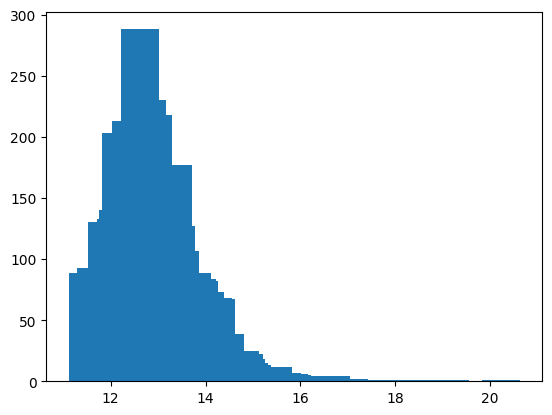

In [28]:
plt.bar( count.keys(),count.values())

# Random forest regressor

In [34]:
RFR = RandomForestRegressor()

In [35]:
RFR.fit(X_train,Y_train)

RandomForestRegressor()

In [36]:
prediction = RFR.predict(X_test)

In [61]:
del RFR

# KNN

In [42]:
K = KNeighborsRegressor(n_neighbors=5)

In [43]:
K.fit(X_train,Y_train)

KNeighborsRegressor()

In [44]:
prediction = K.predict(X_test)

In [ ]:
del K

# Logistic regression

In [133]:
LG = LogisticRegression()
LG.fit(X_train,Y_train)

LogisticRegression()

In [134]:
prediction = LG.predict(X_test)

In [59]:
del LG

NameError: name 'LG' is not defined

# Random Forest

In [30]:
model = RandomForestClassifier(20)

In [31]:
model.fit(X_train,Y_train)

MemoryError: could not allocate 77201408 bytes

In [ ]:
prediction = model.predict(X_test)

In [60]:
#del model

# Prediction calcul

In [37]:
c = 0
for x, y in zip(Y_test, prediction):
    if x == y:
        c += 1

Accuracy = c / Y_test.shape[0]

print('Accuracy:' + str(Accuracy))

Accuracy:0.0009360666479453337


In [38]:
for i, j in zip(Y_10000,prediction):
    print('valeur '+str(i))
    print('deviné '+str(j)+'\n')

valeur 58
deviné 15.86

valeur 60
deviné 28.6

valeur 72
deviné 27.47

valeur 32
deviné 41.82

valeur 32
deviné 72.89

valeur 22
deviné 51.81

valeur 28
deviné 33.79

valeur 20
deviné 104.68

valeur 68
deviné 35.02

valeur 44
deviné 62.18

valeur 43
deviné 57.09

valeur 66
deviné 50.12

valeur 82
deviné 39.46

valeur 29
deviné 48.32

valeur 41
deviné 67.67

valeur 50
deviné 345.21

valeur 25
deviné 128.13

valeur 62
deviné 109.55

valeur 30
deviné 78.52

valeur 50
deviné 78.38

valeur 76
deviné 172.32

valeur 34
deviné 13.82

valeur 51
deviné 64.925

valeur 72
deviné 41.93

valeur 15
deviné 61.5

valeur 96
deviné 49.66

valeur 44
deviné 141.34

valeur 30
deviné 83.1

valeur 21
deviné 41.15

valeur 125
deviné 100.02

valeur 21
deviné 27.85

valeur 31
deviné 146.95

valeur 48
deviné 33.17

valeur 38
deviné 31.41

valeur 115
deviné 140.0

valeur 35
deviné 15.46

valeur 31
deviné 30.49

valeur 10
deviné 265.36

valeur 45
deviné 47.49

valeur 33
deviné 61.56

valeur 36
deviné 31.29

valeur 